In [448]:
import qutip.core.gates
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

In [449]:
# Define basic operators
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

def print_gadget(gadget):
    # Build and print the tensor representation
    tensor_representation = []
    for op in gadget:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        # Check for 0.5(I - Z)
        elif (
            isinstance(op, Qobj)  # Ensure it's a Qobj
            and op.dims == I.dims  # Match single-qubit operator dimensions
            and np.allclose(op.full(), (0.5 * I - 0.5 * Z).full())  # Compare matrices
        ):
            tensor_representation.append("1/2(I-Z)")
        # Fallback for unknown operators
        else:
            tensor_representation.append("Unknown")
    
    print(f"tensor({', '.join(tensor_representation)})")
    
    
def tensor_to_str(operator):
    # Build and print the tensor representation
    tensor_representation = []
    for op in operator:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        else:
            tensor_representation.append("Unknown")
    
    return f"{''.join(tensor_representation)}"

In [450]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")

In [457]:
def prep_aux_test(k, i, current_position, tot_space):
    # Construct the ancillary Hamiltonian
    anc_accum = 0
    for j in range(i + 1, k):
        # Construct the pairwise interaction term for the ancillary space
        ZZ = [(Z if idx == i or idx == j else I) for idx in range(k)]
        aux_H = 0.5*(tensor([I for _ in range(k)]) - tensor(ZZ))
        
        # Embed aux_H into the full space
        pre_space = [I for _ in range(current_position - total_logic_qbits)]  # Identities before this auxiliary block
        post_space = [I for _ in range(tot_space - current_position - k)]  # Identities after this block
        full_aux_H = tensor(pre_space + [aux_H] + post_space)
        
        anc_accum += full_aux_H
        ###### FOR PRINTING Aux #######
        to_p = (pre_space + ZZ + post_space)
        print_gadget(to_p)
        ###### FOR PRINTING Aux #######
        
    return anc_accum

In [632]:
def prep_aux_gad(k, current_position, tot_space, j):
    aux_H = 0.5 * (tensor([0.5 * (I - (Z if j  == i else I)) for i in range(k)]))
    
    # Embed aux_H into the full space
    pre_space = [I for _ in range(current_position)]  # Identities before this auxiliary block
    post_space = [I for _ in range(tot_space - current_position - k)]  # Identities after this block    
    full_aux_H = tensor(pre_space + [aux_H] + post_space)

    ####### FOR PRINTING Aux #######
    to_p = (
        pre_space
        + [0.5 * (I - (Z if j  == i else I)) for i in range(k)]
        + post_space
    )
    print_gadget(to_p)
    ####### FOR PRINTING Aux #######


    return full_aux_H


def prep_aux_gad_jordan(k, i, current_position, tot_space):
    # Construct the ancillary Hamiltonian
    anc_accum = 0
    for j in range(i + 1, k):
        # Construct the pairwise interaction term for the ancillary space
        ZZ = [(Z if idx == i or idx == j else I) for idx in range(k)]
        aux_H = 0.5*(tensor([I for _ in range(k)]) - tensor(ZZ))
        
        # Embed aux_H into the full space
        pre_space = [I for _ in range(current_position)]  # Identities before this auxiliary block
        post_space = [I for _ in range(tot_space - current_position - k)]  # Identities after this block
        full_aux_H = tensor(pre_space + [aux_H] + post_space)
        
        anc_accum += full_aux_H
        ###### FOR PRINTING Aux #######
        to_p = (pre_space + ZZ + post_space)
        print_gadget(to_p)
        ###### FOR PRINTING Aux #######
        
    return anc_accum


def prep_v_gad(k, op, index, j, aux_count_v, current_position, ks):
    logical_operator = tensor(
        [op if i == j else I for i in range(total_logic_qbits)]
    )
    
    # aux = [X if i == (j % k) else X if i == (j + 1) % k else I for i in range(k)]
    aux = [X if i == aux_count_v else I for i in range(k)]
    auxiliary_operator = tensor(aux)
    
    # Embed auxiliary operator into the full auxiliary space
    pre_aux = [I for _ in range(current_position - total_logic_qbits)]  # Identities for earlier stabilizers
    post_aux = [I for _ in range(sum(ks[index + 1:]))]  # Identities for remaining stabilizers
    full_auxiliary_operator = tensor(pre_aux + [auxiliary_operator] + post_aux)
    
    # Combine logical and full auxiliary operators
    full_v = tensor(logical_operator, full_auxiliary_operator)            

    ####### FOR PRINTING V #######
    # to_p = [op if i == j else I for i in range(total_logic_qbits)] + pre_aux + [X if i == (j % k) else X if i == (j + 1) % k else I for i in range(k)] + post_aux
    to_p = [op if i == j else I for i in range(total_logic_qbits)] + pre_aux + aux + post_aux
    print_gadget(to_p)
    ####### FOR PRINTING V #######
    
    return full_v


def prep_v_aux(k, op, index, j, aux_count_v, current_position, ks):
    logical_operator = tensor(
        [op if i == j else I for i in range(total_logic_qbits)]
    )
    
    # aux = [X if i == (j % k) else X if i == (j + 1) % k else I for i in range(k)]
    aux = [X if i == aux_count_v else I for i in range(k)]
    auxiliary_operator = tensor(aux)
    
    ####### FOR PRINTING V #######
    to_p = aux
    print_gadget(to_p)
    ####### FOR PRINTING V #######
    
    return auxiliary_operator

In [741]:
def prep_gadget(perturbation_factor, hs, total_logic_qbits):
    ks = [sum(1 for op in operator if op != I) for operator in hs]  # Auxiliary qubits for each stabilizer
    tot_space = total_logic_qbits + sum(ks)
    
    # Initialize the total Hamiltonian
    H_gad = 0
    H_anc = 0
    VLambda = 0
    # Build auxiliary Hamiltonians and embed them
    current_position = total_logic_qbits  # Start after logical qubits
    for index, operator in enumerate(hs):
        k = sum(1 for op in operator if op != I)    
        
        for j in range(k):
            full_aux_H = prep_aux_gad_jordan(k, j, current_position, tot_space)
            H_anc += prep_aux_test(k, j, current_position, tot_space)
            # H_anc += full_aux_H
            
            # full_aux_H = prep_aux_gad(k, current_position, tot_space, j)
            H_gad += full_aux_H
            
        # Now adding the perturbative terms
        aux_count_v = 0
        for j, op in enumerate(operator):
            if op == I:
                continue     
            
            full_v = prep_v_gad(k, op, index, j, aux_count_v, current_position, ks)
            v_aux = prep_v_aux(k, op, index, j, aux_count_v, current_position, ks)
            aux_count_v += 1
            
            H_gad += perturbation_factor*full_v
            VLambda += perturbation_factor*full_v
    
        current_position += k
        print()
    
    print("Total Hamiltonian Dimensions:", H_gad.dims)
    return tot_space, H_gad, ks, H_anc, VLambda



h1 = [X, Z, Z, X]
h2 = [X, Z, X, X]
h3 = [X, I, Y, I]

hs = [h1]

# Parameters
total_logic_qbits = 4  # Number of logical qubits

perturbation_factor = 0.1
tot_space, H_gad, ks, H_anc, VLambda = prep_gadget(perturbation_factor, hs, total_logic_qbits)


tensor(I, I, I, I, Z, Z, I, I)
tensor(I, I, I, I, Z, I, Z, I)
tensor(I, I, I, I, Z, I, I, Z)
tensor(Z, Z, I, I)
tensor(Z, I, Z, I)
tensor(Z, I, I, Z)
tensor(I, I, I, I, I, Z, Z, I)
tensor(I, I, I, I, I, Z, I, Z)
tensor(I, Z, Z, I)
tensor(I, Z, I, Z)
tensor(I, I, I, I, I, I, Z, Z)
tensor(I, I, Z, Z)
tensor(X, I, I, I, X, I, I, I)
tensor(X, I, I, I)
tensor(I, Z, I, I, I, X, I, I)
tensor(I, X, I, I)
tensor(I, I, Z, I, I, I, X, I)
tensor(I, I, X, I)
tensor(I, I, I, X, I, I, I, X)
tensor(I, I, I, X)

Total Hamiltonian Dimensions: [[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]]


In [742]:
k=4
X_k = tensor([X for _ in range(k)])
I_K = tensor([I for _ in range(k)])

X_s_k = tensor(I_K, X_k)

P_plus = 0.5*(tensor([I for _ in range(8)]) + X_s_k)

H_plus = P_plus * H_gad * P_plus 
eigs_p, vecs_p = H_plus.eigenstates()
energies_p = {}
vecs_low = [] 
P0 = 0
for e, v in zip(eigs_p, vecs_p):
    en = int(np.round(e, 2))
    if en == 0:
        vecs_low.append(v)
        P0 += v*v.dag()
    if en in energies_p.keys():
        energies_p[en] += 1
    else:
        energies_p[en] = 1

print(f"there are d = {len(vecs_low)} low eigenstates")
A = P0 * VLambda * P0

Heff = P0 * A * P0
print(f"Heff eigenstates: {Heff.dims}")
eig, vec = Heff.eigenstates()
print(eig)

there are d = 144 low eigenstates
Heff eigenstates: [[2, 2, 2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2, 2, 2]]
[-4.00000000e-01 -4.00000000e-01 -4.00000000e-01 -4.00000000e-01
 -4.00000000e-01 -4.00000000e-01 -4.00000000e-01 -4.00000000e-01
 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01
 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01
 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01
 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01
 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01
 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01
 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01
 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01 -2.00000000e-01
 -2.69607450e-02 -2.69607450e-02 -2.69607450e-02 -2.69607450e-02
 -2.69607450e-02 -2.69607450e-02 -2.69607450e-02 -2.69607450e-02
 -2.64327440e-02 -2.64327440e-02 -2.64327440e-02 -2.64327440e-02
 -2.64327440e-02 -2.64327440e-02 -2.64327440e-02 -

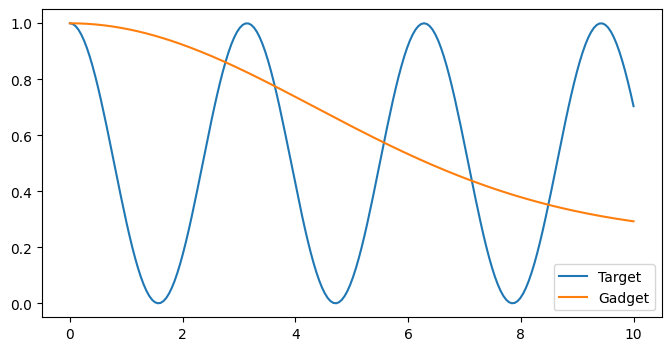

In [743]:
# Create the |++++> state (Hadamard applied to |0000>)
hadamard = qutip.core.gates.hadamard_transform(1)  # Single-qubit Hadamard

num_hadamard_qubits = 4
plus_state_anc = (tensor([basis(2, 0) for _ in range(num_hadamard_qubits)]) + 
                  tensor([basis(2, 1) for _ in range(num_hadamard_qubits)])).unit()
zero_state_target = tensor([basis(2, 0) for _ in range(num_hadamard_qubits)])

times = np.linspace(0, 10, 200)

initial_gad = tensor(zero_state_target, plus_state_anc)

evolution_gad = sesolve(Heff, initial_gad, times, e_ops=[initial_gad*initial_gad.dag()])
evolution = sesolve(tensor(h1), zero_state_target, times, e_ops=[zero_state_target*zero_state_target.dag()])

plt.figure(figsize=(8,4))
plt.plot(times, evolution.expect[0], label=r"Target")
plt.plot(times, evolution_gad.expect[0], label=r"Gadget")
plt.legend()
plt.show()


In [453]:
H_time_independent = [X,Z,X,X]
H_ind_gad = tensor(H_time_independent + [I for _ in range(sum(ks))])
H_ind_reg = tensor(H_time_independent)

# Number of qubits for the |++++> state
num_hadamard_qubits = total_logic_qbits

# Number of qubits for the entangled state
num_entangled_qubits = sum(ks)

# Create the |++++> state (Hadamard applied to |0000>)
hadamard = qutip.core.gates.hadamard_transform(1)  # Single-qubit Hadamard

plus_state_target = tensor([hadamard * basis(2, 0) for _ in range(num_hadamard_qubits)])
zero_state_target = tensor([basis(2, 0) for _ in range(num_hadamard_qubits)])

# Create the entangled state (1/sqrt(2) * (|00...0> + |11...1>))
zero_state = tensor([basis(2, 0) for _ in range(num_entangled_qubits)])
one_state = tensor([basis(2, 1) for _ in range(num_entangled_qubits)])
entangled_state = (zero_state + one_state).unit()

# Combine |++++> and the entangled state
state_plus_entangled = (tensor(plus_state_target, zero_state) + tensor(plus_state_target, one_state)).unit()
state_zero_entangled = (tensor(zero_state_target, zero_state) + tensor(zero_state_target, one_state)).unit()


print_quantum_state_as_superposition(state_zero_entangled)

H = 0
for i in hs:
    H += tensor(i)

|ψ⟩ = 0.71|00000000⟩ + 0.71|00001111⟩


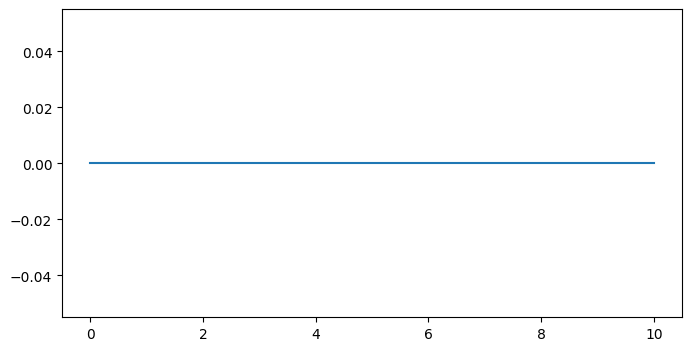

In [454]:
# Generating Pulse
max_time = 10
times = np.linspace(0, max_time, 200)

pulse = 0
omega_max = 50
sigma =0.5
delta_t = lambda t: pulse * (t / (max_time / 2) - 1)
# delta_t = lambda t: omega_max * np.exp(-0.5 * ((t - max_time/2) / sigma) ** 2)    


plt.figure(figsize=(8,4))
plt.plot(times, delta_t(times))
plt.show()

D = 256


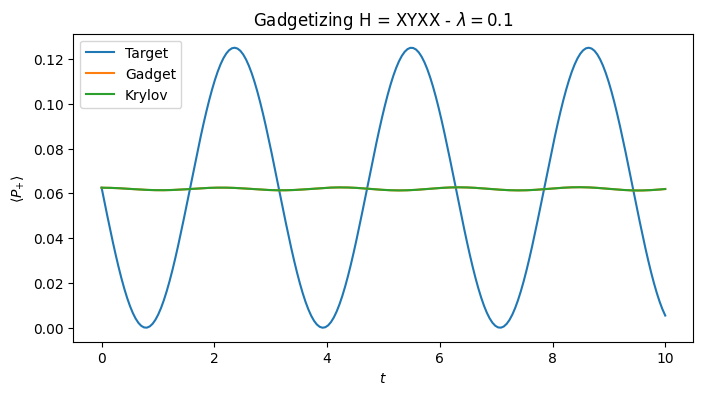

In [598]:
P_plus_gad = state_plus_entangled * state_plus_entangled.dag()
P_plus = plus_state_target * plus_state_target.dag()
P_zero_gad = state_zero_entangled * state_zero_entangled.dag()
P_zero = zero_state_target * zero_state_target.dag()
e_ops_gad = [P_plus_gad, P_zero_gad]
e_ops = [P_plus, P_zero]

# [[H_ind_gad, delta_t], H_gad]
evolution_gad = sesolve(H_gad, state_plus_entangled, times, e_ops=e_ops_gad)
# [[H_ind_reg, delta_t], H]
evolution = sesolve(H, plus_state_target, times, e_ops=e_ops)

krylov_dim = 5  # Adjust this parameter as needed for accuracy vs. performance
print(f"D = {2 ** len(H_gad.dims[0])}")
evolution_krylov = krylovsolve(H_gad, state_plus_entangled, times, e_ops=e_ops_gad, krylov_dim=krylov_dim)

plt.figure(figsize=(8, 4))
plt.plot(times, evolution.expect[1], label=r"Target")
plt.plot(times, evolution_gad.expect[1], label=r"Gadget")
plt.plot(times, evolution_krylov.expect[1], label=r"Krylov")
plt.legend()
plt.ylabel(r"$\langle P_{+} \rangle$")
plt.xlabel(r"$t$")

title = ""
for h in hs:
    title += tensor_to_str(h) + " + "
    
plt.title("Gadgetizing H = " + title[:-3] + r" - $\lambda = $" + f'{perturbation_factor}')
plt.show()